In [30]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import datetime as dt
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from matplotlib.collections import LineCollection
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
from sklearn.cross_validation import train_test_split
%matplotlib notebook

C:\Users\GRANVILLE\Anaconda2\Lib\site-packages\IPython\kernel\__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


# Data Load

In [29]:
##This dataset contains incidents derived from SFPD Crime Incident Reporting system. 
##The data ranges from 1/1/2003 to 5/13/2015. The training set and test set rotate every 
##week, meaning week 1,3,5,7... belong to test set, week 2,4,6,8 belong to training set. 

##Data fields
##Dates - timestamp of the crime incident
##Category - category of the crime incident (only in train.csv). This is the target variable you are going to predict.
##Descript - detailed description of the crime incident (only in train.csv)
##DayOfWeek - the day of the week
##PdDistrict - name of the Police Department District
##Resolution - how the crime incident was resolved (only in train.csv)
##Address - the approximate street address of the crime incident 
##X - Longitude
##Y - Latitude

In [27]:
DATA_DIR = ".\\data"
TRAINING_FILE_NAME = "train.csv"
TEST_FILE_NAME = "test.csv"
TRAINING_FILE_FULL_NAME = os.path.join(DATA_DIR, TRAINING_FILE_NAME)
TEST_FILE_FULL_NAME = os.path.join(DATA_DIR, TEST_FILE_NAME)

In [3]:
df = pd.read_csv(TRAINING_FILE_FULL_NAME,parse_dates=["Dates"])

In [4]:
df.describe(include="all")

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
count,878049,878049,878049,878049,878049,878049,878049,878049.000000,878049.000000
unique,389257,39,879,7,10,17,23228,NaN,NaN
top,2011-01-01 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Friday,SOUTHERN,NONE,800 Block of BRYANT ST,NaN,NaN
freq,185,174900,60022,133734,157182,526790,26533,NaN,NaN
first,2003-01-06 00:01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2015-05-13 23:53:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-122.422616,37.771020
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.030354,0.456893
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-122.513642,37.707879
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-122.432952,37.752427


# Data Visualization

In [60]:
def plot_graph(df,groupby, k, color):
    plt.figure()
    df.groupby(groupby).size().plot(kind=k,color=color,figsize=(8,6),rot=90)

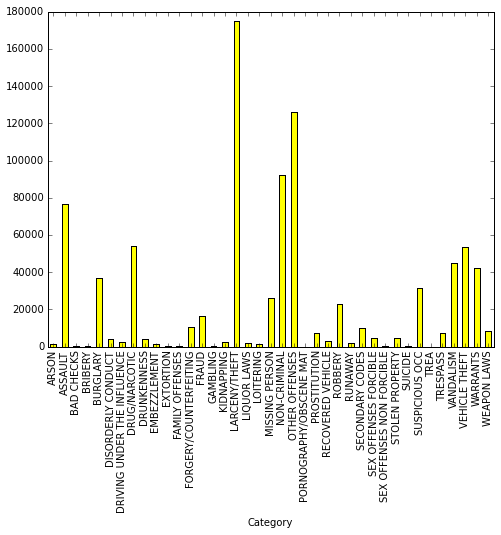

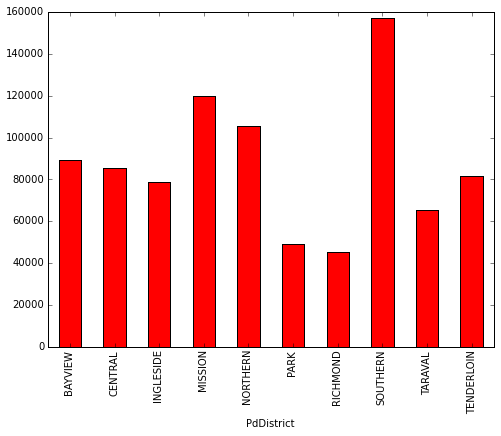

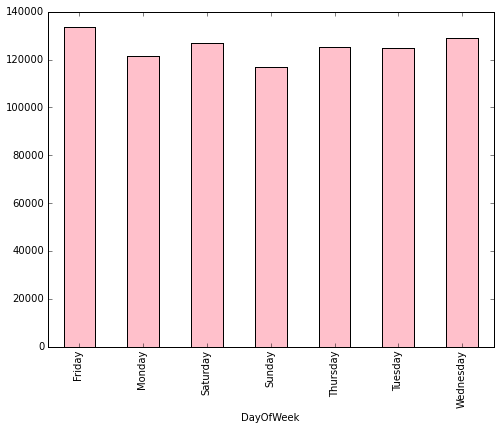

In [61]:
plot_graph(df, "Category", "bar", "yellow")
plot_graph(df, "PdDistrict", "bar", "red")
plot_graph(df, "DayOfWeek", "bar", "pink")

# Visualization of values evolution

In [5]:
df["year"] = df["Dates"].dt.year
df["month"] = df["Dates"].dt.month
df["day"] = df["Dates"].dt.day
df["hour"] = df["Dates"].dt.hour
df["minute"] = df["Dates"].dt.minute
#seconds are obviously irrelevant
%time

Wall time: 0 ns


In [41]:
df.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,year,month,day,hour,minute
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,23,53
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,23,53
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,2015,5,13,23,33
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,2015,5,13,23,30
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,2015,5,13,23,30


In [43]:
districtPerYear = pd.pivot_table(df, index="year", columns="PdDistrict", values="Dates", aggfunc="count")
districtPerYearPerDay = pd.pivot_table(df, index=["year", "DayOfWeek"], columns="PdDistrict", values="Dates", aggfunc="count")
print(districtPerYearPerDay)

PdDistrict      BAYVIEW  CENTRAL  INGLESIDE  MISSION  NORTHERN  PARK  \
year DayOfWeek                                                         
2003 Friday        1156     1027       1056     1637      1463   663   
     Monday        1159      906        990     1502      1238   635   
     Saturday      1065     1007        909     1461      1282   550   
     Sunday        1099      875        854     1217      1192   523   
     Thursday      1122      970       1065     1584      1423   572   
     Tuesday       1192      947       1002     1614      1292   598   
     Wednesday     1157      947       1019     1562      1408   594   
2004 Friday        1211     1077       1098     1634      1491   604   
     Monday        1115      884       1002     1330      1228   556   
     Saturday      1185     1105        919     1376      1162   558   
     Sunday        1056      911        927     1259      1212   517   
     Thursday      1160      933       1012     1543      1349  

<IPython.core.display.Javascript object>


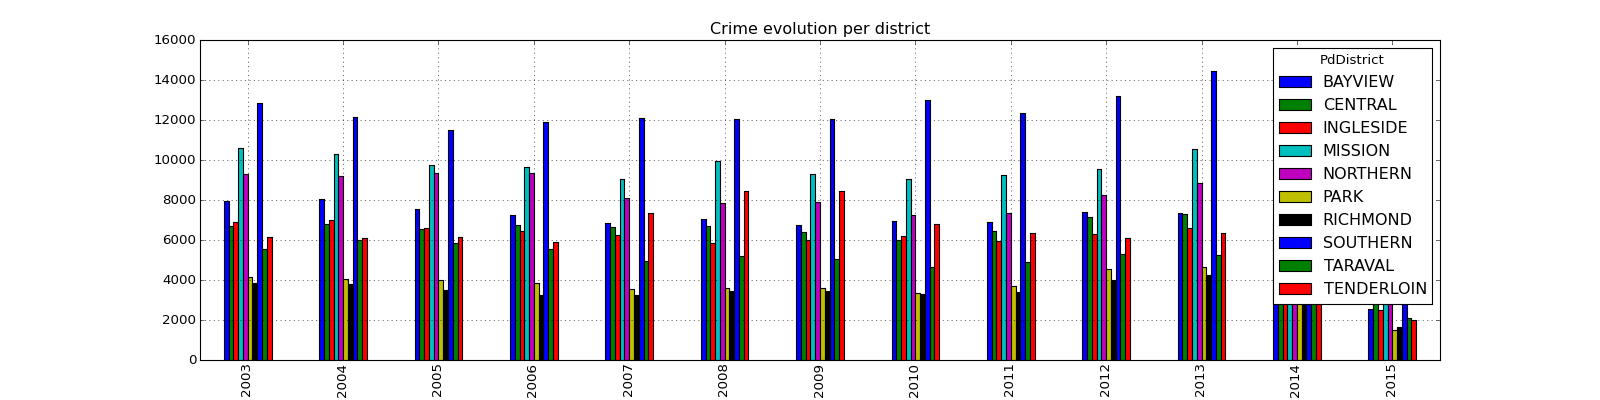

Wall time: 511 ms


In [44]:
%time districtPerYear.plot(kind = "bar", title="Crime evolution per district", figsize=(20,5), grid=True, legend=True)

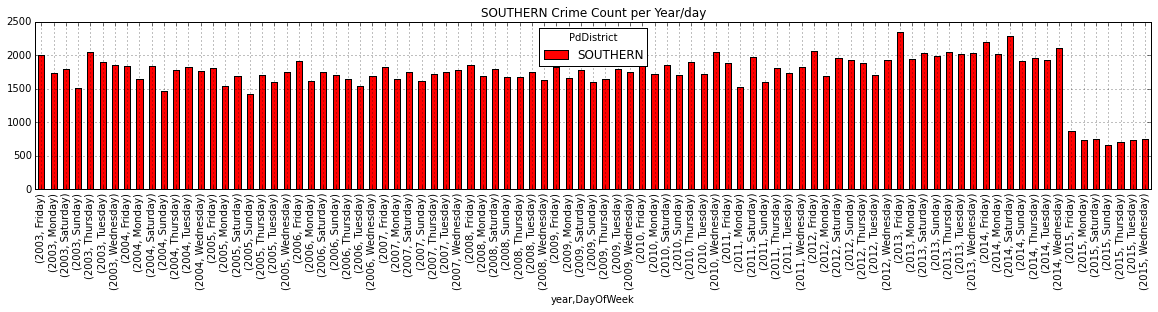

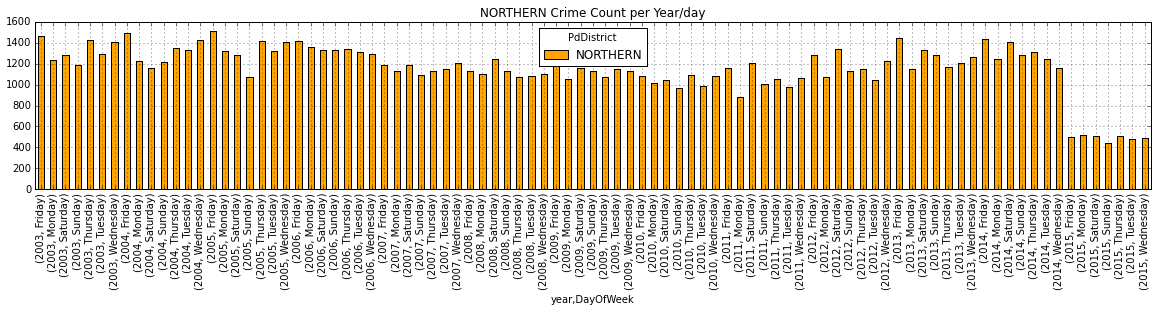

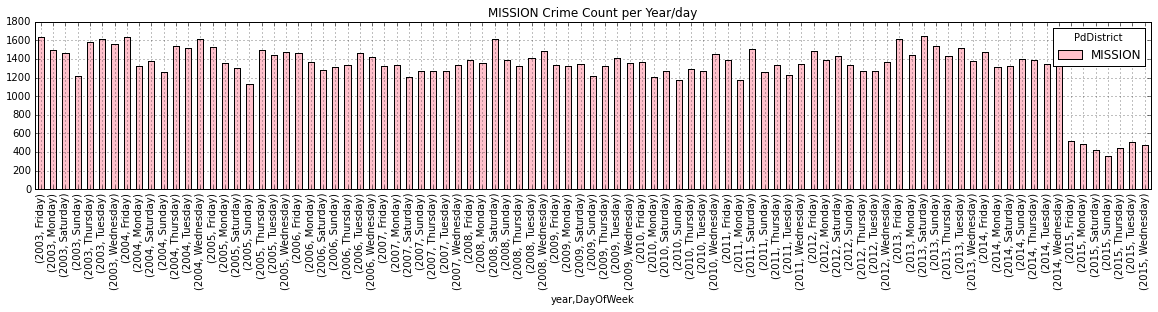

In [63]:
districtPerYearPerDay[["SOUTHERN"]].plot(kind ="bar", title="SOUTHERN Crime Count per Year/day", figsize=(20,3), grid=True, color="red")
districtPerYearPerDay[["NORTHERN"]].plot(kind ="bar", title="NORTHERN Crime Count per Year/day", figsize=(20,3), grid=True, color="orange")
districtPerYearPerDay[["MISSION"]].plot(kind ="bar", title="MISSION Crime Count per Year/day", figsize=(20,3), grid=True, color="pink")

In [64]:
CategoryPerYear = pd.pivot_table(df, index="year", columns="Category", values="Dates", aggfunc="count")
CategoryPerYearPerDay = pd.pivot_table(df, index=["year", "DayOfWeek"], columns="Category", values="Dates", aggfunc="count")

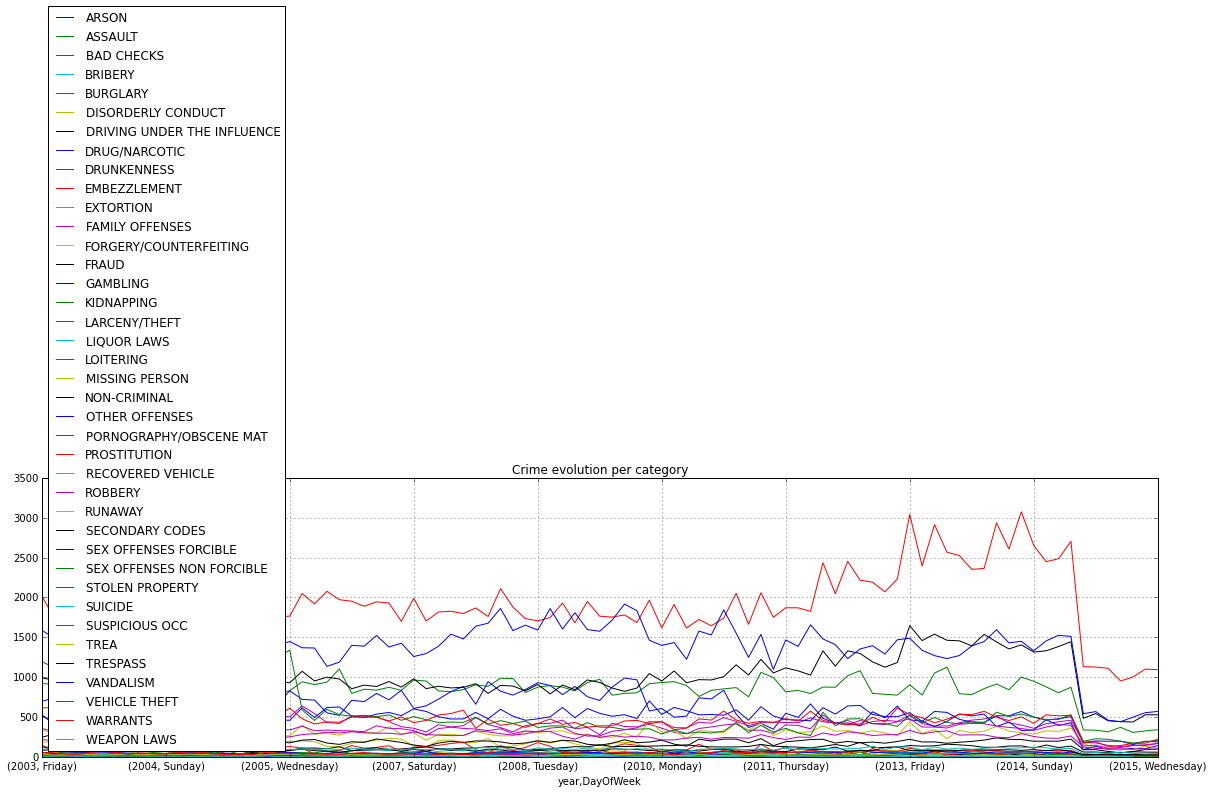

In [65]:
ax = CategoryPerYearPerDay.plot(kind = "line", title="Crime evolution per category", figsize=(20,5), grid=True, legend=False)
patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, labels, loc=3)

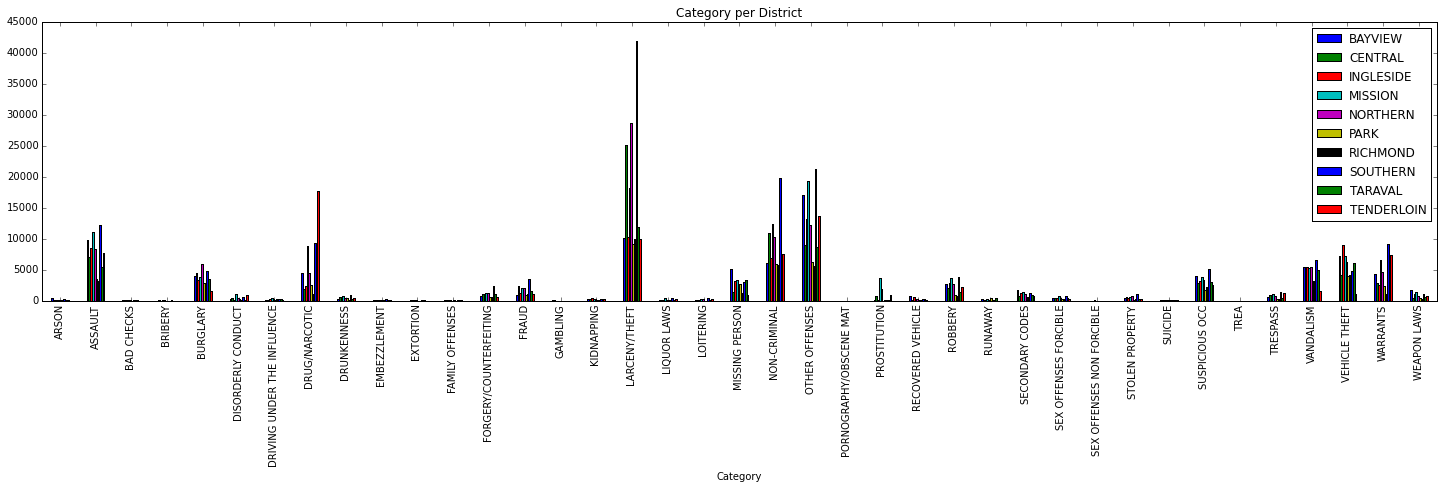

In [66]:
categoryPerDistrict = df.pivot_table(index=["Category"],columns=["PdDistrict"],values="Dates",aggfunc="count")
ax = categoryPerDistrict.plot(kind="bar", figsize=(25,5), title="Category per District")
patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, labels, loc=1)

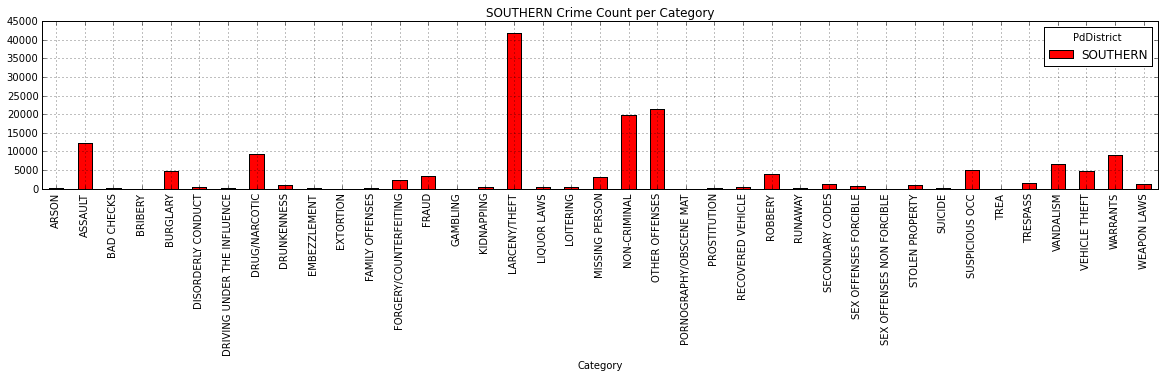

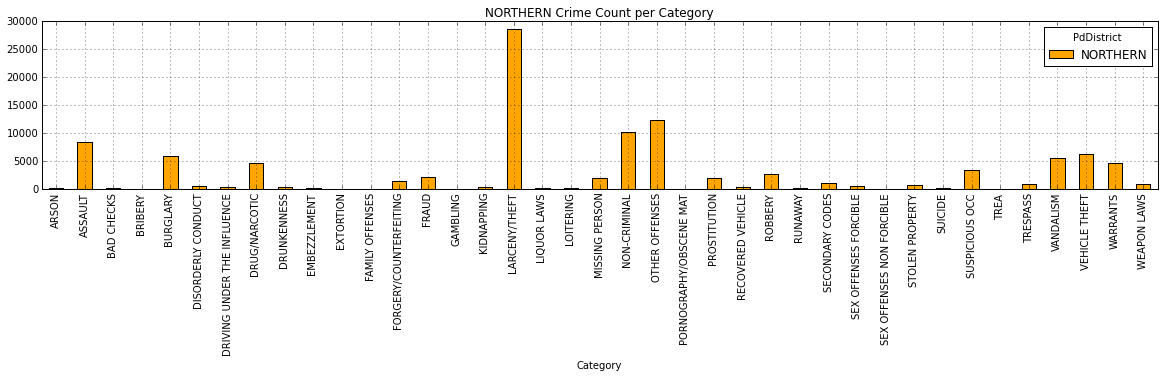

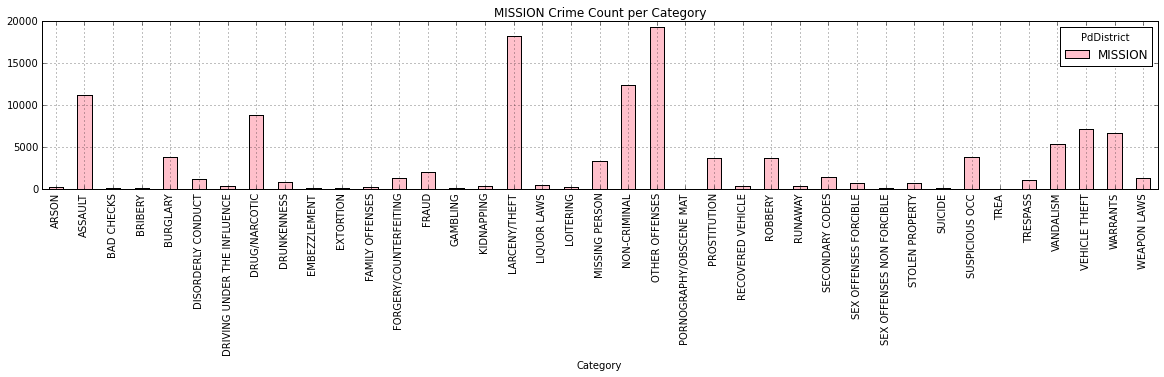

In [67]:
categoryPerDistrict[["SOUTHERN"]].plot(kind ="bar", title="SOUTHERN Crime Count per Category", figsize=(20,3), grid=True, color="red")
categoryPerDistrict[["NORTHERN"]].plot(kind ="bar", title="NORTHERN Crime Count per Category", figsize=(20,3), grid=True, color="orange")
categoryPerDistrict[["MISSION"]].plot(kind ="bar", title="MISSION Crime Count per Category", figsize=(20,3), grid=True, color="pink")

In [19]:
def convertToFloat(v):
    return float(str(v)[:10])

xValues = map(convertToFloat, df["X"].values)
yValues = map(convertToFloat, df["Y"].values)

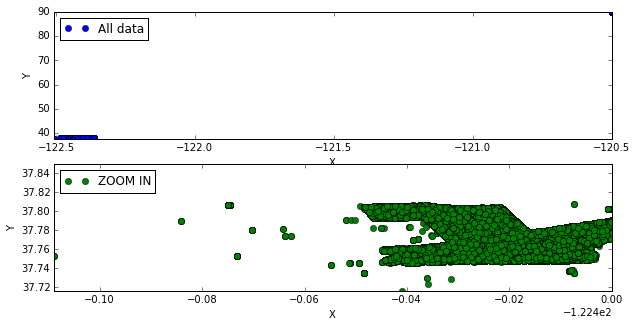

In [28]:
def drawXYGraph(x,y):
    plt.figure(figsize=(10,5))
    plt.subplot(211)
    plt.plot(x, y,'ro', label ="All data",color="blue")
    plt.axis([min(x), max(x), min(y), max(y)])
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend(loc=0)
    plt.subplot(212)
    plt.plot(x, yValues,'ro',color="green", label= "ZOOM IN")
    plt.axis([min(x), -122.4, min(y), 37.85])
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend(loc=0)

drawXYGraph(xValues,yValues)

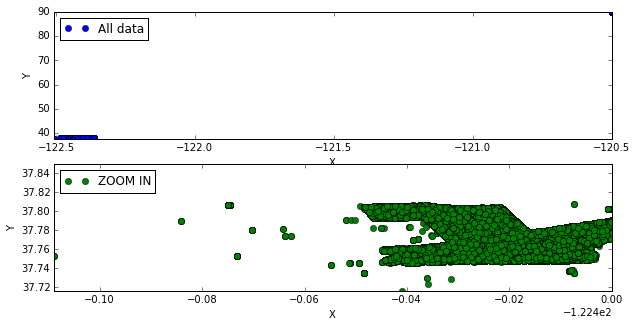

In [29]:
dfCrimeTop3 = df[df['PdDistrict'].isin(['SOUTHERN','NORTHERN','MISSION'])]
xValues = map(convertToFloat, dfCrimeTop3["X"].values)
yValues = map(convertToFloat, dfCrimeTop3["Y"].values)
drawXYGraph(xValues,yValues)

In [16]:
XMAX = max(df.X.tolist())
XMIN = min(df.X.tolist())
YMIN = min(df.Y.tolist())
YMAX = max(df.Y.tolist())
df["X_new"] = df["X"].apply(lambda x : round(x, 4))
df["Y_new"] = df["Y"].apply(lambda x : round(x, 4))

In [14]:
LLLON = -122.54425048828125#-122.513642 #longitude of lower left hand corner of the selected map domain.
URLON = -122.28607177734376#-120.500000 #longitude of upper right hand corner of the selected map domain.
LLLAT = 37.62945956107554#37.707879 #latitude of lower left hand corner of the selected map domain.
URLAT = 37.8293108128250#45 #latitude of upper right hand corner of the selected map domain.

def plot_SF_map(dfDistrict, lllon, urlon, lllat, urlat,Xlabel="X_new",Y_label="Y_new"):
    plt.figure()
    sfmap = Basemap(projection='stere', 
                resolution="f", 
                llcrnrlat=lllat, 
                urcrnrlat=urlat, 
                llcrnrlon=lllon,
                urcrnrlon=urlon,
                lon_0=(urlon+lllon)/2,
                lat_0=(lllat + urlat)/2)

    sfmap.drawcoastlines()
    sfmap.drawcountries()
    sfmap.drawstates()
    
    color_map = {}
    for i in range(len(dfDistrict.PdDistrict.unique())):
        color_map[dfDistrict.PdDistrict.unique()[i]] = colors.cnames.keys()[i]
    
    XY_map = {}
    for i in range(len(dfDistrict.index.values)):
        X = dfDistrict.iloc[i]["X_new"]
        Y = dfDistrict.iloc[i]["Y_new"]
        if not X in XY_map:
            XY_map[X] = Y
            sfmap.plot(X,Y,'bo',markersize=5,color=color_map[dfDistrict.iloc[i]["PdDistrict"]], latlon=True)      
    plt.show()

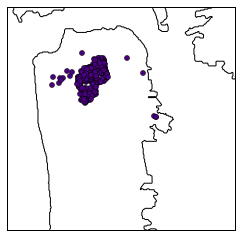

Wall time: 2min 4s


In [17]:
dfDistrict = df[df.PdDistrict == "PARK"]
%time plot_SF_map(dfDistrict, LLLON, URLON, LLLAT, URLAT)

<IPython.core.display.Javascript object>


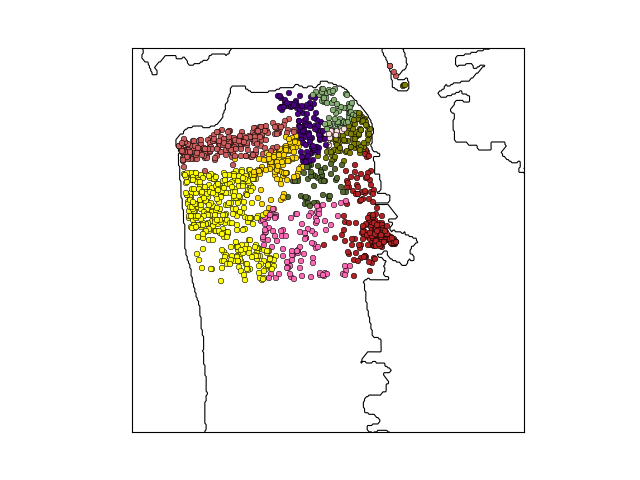

Wall time: 10min 50s


In [38]:
%time plot_SF_map(df, LLLON, URLON, LLLAT, URLAT)

# Average position of offences

In [23]:
dfOffences = df.pivot_table(columns="PdDistrict", aggfunc="count", index="Category", values="Dates", margins=True).sort_values(by="All", ascending=False)
dfOffencesAvgPosition = df.pivot_table(aggfunc=np.mean, index="Category", values=["X","Y"])
for cat in dfOffencesAvgPosition.index.tolist():
    dfOffencesAvgPosition.loc[cat,"Crimes"] = dfOffences.loc[cat,"All"]
dfOffencesAvgPosition.head()

,X,Y,Crimes
Category,,,
ARSON,-122.419799,37.757478,1513
ASSAULT,-122.421062,37.766595,76876
BAD CHECKS,-122.423752,37.769944,406
BRIBERY,-122.418650,37.754059,289
BURGLARY,-122.426357,37.769464,36755


In [25]:
def plot_3D_map(dfDistrict, lllon, urlon, lllat, urlat):
    map = Basemap(projection='stere', 
                  resolution="f", 
                  llcrnrlat=lllat, 
                  urcrnrlat=urlat, 
                  llcrnrlon=lllon,
                  urcrnrlon=urlon,
                  lon_0=(urlon+lllon)/2,
                  lat_0=(lllat + urlat)/2)

    fig = plt.figure()
    ax = Axes3D(fig)

    #ax.set_axis_off()
    #ax.azim = 270
    #ax.dist = 3

    polys = []
    for polygon in map.landpolygons:
        polys.append(polygon.get_coords())
    

    lc = PolyCollection(polys, edgecolor='black',facecolor='#DDDDDD', closed=False)

    ax.add_collection3d(lc)
    ax.add_collection3d(map.drawcoastlines(linewidth=0.25))
    ax.add_collection3d(map.drawcountries(linewidth=0.35))
    
    
     

    lons = dfDistrict.X.values #np.array([-13.7, -10.8, -13.2, -96.8, -7.99, 7.5, -17.3, -3.7])
    lats = dfDistrict.Y.values #np.array([9.6, 6.3, 8.5, 32.7, 12.5, 8.9, 14.7, 40.39])
    crimes = dfDistrict.Crimes.values #np.array([1192, 2964, 1250, 1, 5, 8, 0, 0])
    districts = dfDistrict.index.values #np.array(['Guinea', 'Liberia', 'Sierra Leone','United States', 'Mali', 'Nigeria', 'Senegal', 'Spain'])
    nb_colors = len(crimes)
    
    x, y = map(lons, lats)

    ax.bar3d(x, y, np.zeros(len(x)), 1, 1, crimes, color=colors.cnames.values()[:nb_colors], alpha=1, label = districts)
    #plt.legend(loc=0)
    plt.show()

<IPython.core.display.Javascript object>


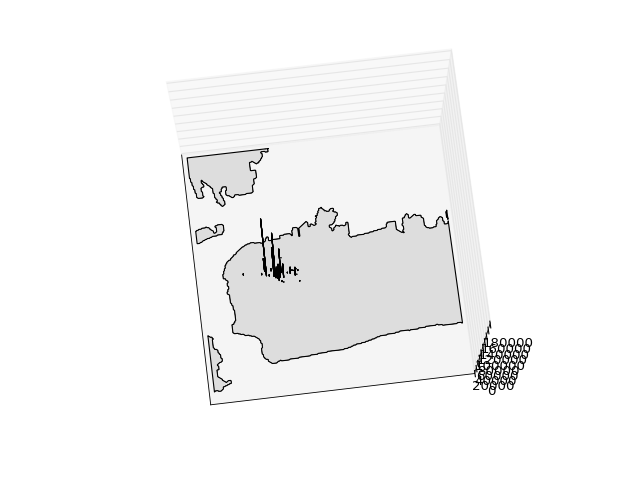

Wall time: 1min 31s


In [31]:
%time plot_3D_map(dfOffencesAvgPosition, LLLON, URLON, LLLAT, URLAT)